In [159]:
import pandas as pd
import seaborn as sns
from gurobipy import *
import matplotlib.pyplot as plt
import gurobipy as gp
import numpy as np

import matplotlib.pyplot as pl#t
plt.rcParams.update({'font.size': 22})

In [160]:
### calculate a given mape for a daily df

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

# functions

def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function
    actual = pd.Series(actual)
    forecast = pd.Series(forecast)

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    print(ft_wmape_forecast)
    # return a float
    return "WMAPE",ft_wmape_forecast

def mean_absolute_percentage_error(y_true, y_pred):
    return "MAPE", np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return "MAE",mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    rms = mean_squared_error(y_true, y_pred, squared=False)
    return "RMSE", rms

def mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=True)
    return "MSE", mse

def medae(y_true, y_pred):
    return "MEDAE", median_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return "R2",r2_score(y_true, y_pred)

def msle(y_true, y_pred):
    return "MSLE", mean_squared_log_error(y_true, y_pred)

def maape(y_true,y_pred): # https://www.sciencedirect.com/science/article/pii/S0169207016000121
    EPSILON = 1e-10
    return "MAAPE", np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))

### from peak challenge
def get_peak_values_from_loadpatterm(loadpattern):
  peakvalues = []
  for i in range (int(len(loadpattern)/24)):
    to_consider = loadpattern[i*24:(i+1)*24]
    peakvalues.append(np.max(to_consider))
  return np.array(peakvalues)

def get_peak_times_from_loadpattern(loadpattern):
    peaktimes = []
    for i in range (int(len(loadpattern)/24)):
        to_consider = loadpattern[i*24:(i+1)*24]
        peaktimes.append(to_consider.tolist().index(np.max(to_consider)))
    to_return = np.array(peaktimes)
    to_return = to_return+1
    return to_return


def shape_score (actual_loadpattern,predicted_loadpattern):
    normed_peaksurroundings_actual = []
    normed_peaksurroundings_pred = []
    for block_index in range (int(len(actual_loadpattern)/24)):
        startindex= block_index*24
        block_actual = actual_loadpattern[startindex:(block_index+1)*24]
        peakvalue_actual = np.max(block_actual)
        peakindex_actual  = np.where(block_actual == peakvalue_actual)[0][0]
        normed_actual = actual_loadpattern/peakvalue_actual

        block_pred = predicted_loadpattern[startindex:(block_index+1)*24]
        peakvalue_pred = np.max(block_pred)
        normed_pred = predicted_loadpattern/peakvalue_pred


        normed_peaksurroundings_actual.extend(normed_actual[startindex + peakindex_actual-2:startindex +peakindex_actual+3])
        normed_peaksurroundings_pred.extend(normed_pred[startindex+peakindex_actual-2: startindex+ peakindex_actual+3])
    normed_peaksurroundings_actual = np.array(normed_peaksurroundings_actual)
    normed_peaksurroundings_pred = np.array(normed_peaksurroundings_pred)
    absolute_errors = abs(normed_peaksurroundings_actual-normed_peaksurroundings_pred)
    return "shape_score", np.sum(absolute_errors)

def peaktime_score(actual_peaktimes, predicted_peaktimes):
    absolute_diffs = abs(actual_peaktimes-predicted_peaktimes)
    total_diffs = 0
    for diff in absolute_diffs:
        if abs(diff)<2:
            total_diffs = total_diffs+diff
        elif abs(diff)<5:
            total_diffs = total_diffs+(diff*2)
        else:
            total_diffs = total_diffs+(10)
    return "peaktime_score", total_diffs


def peak_mape(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_mape", mean_absolute_percentage_error(peakvalues_actual,predictions_at_peaktime)[1]

def peak_rmse(actual_values, forecasted_values):
  peakvalues_actual = get_peak_values_from_loadpatterm(actual_values)
  predictions_at_peaktime = get_peak_values_from_loadpatterm(forecasted_values)
  return "peak_rmse", rmse(peakvalues_actual,predictions_at_peaktime)[1]


def peaktime_mae(actual_values, forecasted_values):
  peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
  predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
  return "peaktime_mae", mean_absolute_error(peaktimes_actual,predictions_peaktime)

def percentage_match(peaktimes_actual, predictions_peaktime):
    if len(peaktimes_actual) != len(predictions_peaktime):
        raise ValueError("Arrays must have the same length")

    count_matching = sum(1 for x, y in zip(peaktimes_actual, predictions_peaktime) if x == y)
    total_elements = len(peaktimes_actual)

    percentage = (count_matching / total_elements) * 100
    return percentage

def peaktime_accuracy(actual_values, forecasted_values):
    peaktimes_actual = get_peak_times_from_loadpattern(actual_values)
    predictions_peaktime = get_peak_times_from_loadpattern(forecasted_values)
    result = percentage_match(peaktimes_actual, predictions_peaktime)

    return "peaktime_accuracy", result

# we also evaluate the metrics for the highest n-decile of true value
def highest_decile_metric(y_true,y_pred,function,decile):
    desired_hits = int(len(y_true)*decile)
    ind_highest = np.argpartition(y_true, -desired_hits)[-desired_hits:]
    top_hits_true = y_true[ind_highest]
    top_hits_pred = y_pred[ind_highest]
    name, res = function(top_hits_true,top_hits_pred)
    return name+"_decile_"+str(decile), res

def highest_50_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.5))

def highest_40_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.4))

def highest_30_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.3))

def highest_20_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.2))

def highest_10_decile_rmse(y_true,y_pred):
    return (highest_decile_metric(y_true,y_pred,rmse,0.1))

# evaluation

functions = [mean_absolute_percentage_error,mae,rmse,r2,peak_rmse,peaktime_mae,peaktime_accuracy,highest_50_decile_rmse,highest_30_decile_rmse,highest_20_decile_rmse,highest_10_decile_rmse]

def evaluate_metrics(target_df, functions):
    results = {}
    for function in functions:
        name, res = function(target_df["Agg Load"].values, target_df["Predict"].values)
        results.update({name:res})

    return results

In [180]:
# First, construct results


methods = ["Random Forest","RF CEEMDAN","XGB","XGB CEEMDAN", "LSTM","LSTM CEEMDAN","Transformer"]
nn_methods = ["LSTMMSE","LSTM","LSTM CEEMDAN","Transformer"]

hh_results = pd.DataFrame()
hp_results = pd.DataFrame()
total_results = pd.DataFrame()

hh_comparison = pd.DataFrame()
hp_comparison = pd.DataFrame()
total_comparison = pd.DataFrame()

for method in methods:
    print(method)
    comb = pd.DataFrame()
    hp_df = pd.read_pickle("./results/HP "+method+" Results.pkl")
    hh_df = pd.read_pickle("./results/HH "+method+" Results.pkl")
    comb_df = pd.read_pickle("./results/Comb "+method+" Results.pkl")
    if method in nn_methods:
        hp_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        hh_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        comb_df.rename(columns={"NN Forecast":"Predict"},inplace=True)
        
    # creating df for plotting
    hh_comparison.index = hh_df.index
    hp_comparison.index = hp_df.index
    total_comparison.index = comb_df.index
    hh_comparison[method] = hh_df["Predict"].values
    hp_comparison[method] = hp_df["Predict"].values
    total_comparison[method+" Directly Combined"] = comb_df["Predict"].values
    total_comparison[method+ " Individually Aggregated"] = hh_df["Predict"].values + hp_df["Predict"].values
    hh_comparison["Real Load"] = hh_df["Agg Load"].values
    hp_comparison["Real Load"] = hp_df["Agg Load"].values
    total_comparison["Real Load"] = comb_df["Agg Load"].values
    
    
    comb.index = hp_df.index
    comb["Predict"] = hp_df["Predict"] + hh_df["Predict"]
    comb["Agg Load"] = hp_df["Agg Load"] + hh_df["Agg Load"]
    
    
    hp_results[method] = evaluate_metrics(hp_df,functions)
    hh_results[method] = evaluate_metrics(hh_df,functions)
    
    total_results[method+" Individually Aggregated"] =  evaluate_metrics(comb,functions)
    total_results[method+" Directly Combined"] =  evaluate_metrics(comb_df,functions)


Random Forest
RF CEEMDAN
XGB
XGB CEEMDAN
LSTM
LSTM CEEMDAN
Transformer


In [189]:
total_comparison =total_comparison.applymap(lambda x: 0 if x <=0 else x) # correct negative values for RF CEEMDAN and XGB CEEMDAN

In [190]:
total_results_rank = total_results.copy()


# Define which metrics should be ranked in ascending order
ascending_metrics = ['MAPE', 'MAE', 'RMSE', 'peak_rmse', 'peaktime_mae',"RMSE_decile_0.5","RMSE_decile_0.4","RMSE_decile_0.3","RMSE_decile_0.2","RMSE_decile_0.1"]

# Apply ranking row-wise
for metric in total_results.index:
    ascending = metric in ascending_metrics
    total_results_rank.loc[metric] = total_results.loc[metric].rank(method='min', ascending=ascending)
total_results_rank

,Random Forest Individually Aggregated,Random Forest Directly Combined,RF CEEMDAN Individually Aggregated,RF CEEMDAN Directly Combined,XGB Individually Aggregated,XGB Directly Combined,XGB CEEMDAN Individually Aggregated,XGB CEEMDAN Directly Combined,LSTM Individually Aggregated,LSTM Directly Combined,LSTM CEEMDAN Individually Aggregated,LSTM CEEMDAN Directly Combined,Transformer Individually Aggregated,Transformer Directly Combined
MAPE,6.0,8.0,14.0,13.0,4.0,5.0,11.0,12.0,10.0,7.0,3.0,9.0,1.0,2.0
MAE,6.0,9.0,13.0,14.0,5.0,8.0,11.0,12.0,10.0,4.0,3.0,7.0,1.0,2.0
RMSE,5.0,10.0,13.0,14.0,7.0,9.0,11.0,12.0,8.0,4.0,3.0,6.0,1.0,2.0
R2,5.0,10.0,13.0,14.0,7.0,9.0,11.0,12.0,8.0,4.0,3.0,6.0,1.0,2.0
peak_rmse,6.0,9.0,12.0,14.0,7.0,8.0,11.0,13.0,10.0,5.0,3.0,4.0,2.0,1.0
peaktime_mae,2.0,4.0,5.0,11.0,8.0,12.0,13.0,6.0,14.0,3.0,7.0,10.0,1.0,9.0
peaktime_accuracy,8.0,4.0,2.0,11.0,13.0,10.0,6.0,2.0,14.0,6.0,9.0,12.0,1.0,5.0
RMSE_decile_0.5,6.0,9.0,12.0,14.0,7.0,10.0,11.0,13.0,8.0,4.0,3.0,5.0,1.0,2.0
RMSE_decile_0.3,4.0,9.0,11.0,14.0,7.0,10.0,12.0,13.0,6.0,2.0,8.0,5.0,3.0,1.0
RMSE_decile_0.2,4.0,8.0,11.0,14.0,5.0,9.0,12.0,13.0,6.0,1.0,10.0,7.0,3.0,2.0


In [191]:
total_comparison.max()

Random Forest Directly Combined          50943.546192
Random Forest Individually Aggregated    50254.029885
Real Load                                50147.273084
RF CEEMDAN Directly Combined             56053.593717
RF CEEMDAN Individually Aggregated       51591.815284
XGB Directly Combined                    49030.398438
XGB Individually Aggregated              52984.578125
XGB CEEMDAN Directly Combined            47503.980469
XGB CEEMDAN Individually Aggregated      54573.351562
LSTM Directly Combined                   46939.376953
LSTM Individually Aggregated             43449.170898
LSTM CEEMDAN Directly Combined           45597.853893
LSTM CEEMDAN Individually Aggregated     49354.469159
Transformer Directly Combined            49409.175781
Transformer Individually Aggregated      47683.525391
dtype: float64

In [192]:
# set up an empty dataframe for the results after peak shaving

after_peakshaving = pd.DataFrame()
after_peakshaving.index = total_comparison.index
after_peakshaving["Real Load"] = total_comparison["Real Load"].values

In [193]:
# utility function to create from gurobi model results dataframe

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück


In [194]:
target_methods

Index(['Random Forest Directly Combined',
       'Random Forest Individually Aggregated', 'Real Load',
       'RF CEEMDAN Directly Combined', 'RF CEEMDAN Individually Aggregated',
       'XGB Directly Combined', 'XGB Individually Aggregated',
       'XGB CEEMDAN Directly Combined', 'XGB CEEMDAN Individually Aggregated',
       'LSTM Directly Combined', 'LSTM Individually Aggregated',
       'LSTM CEEMDAN Directly Combined',
       'LSTM CEEMDAN Individually Aggregated', 'Transformer Directly Combined',
       'Transformer Individually Aggregated'],
      dtype='object')

In [195]:
target_methods = total_comparison.columns

for target_method in target_methods:
    p_forecast = total_comparison[target_method]
    storage_size = total_comparison["Real Load"].max()
    print(storage_size)

    n_timesteps = len(p_forecast)
    days = int(total_comparison.shape[0]/24)
    m  = Model("DSM")  #Erstellt eine Instanz eines Gurobi-Gptimierungsmodellsa
    p_agg = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_agg")    
    p_ch_opt = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_ch_opt")    
    p_dch_opt = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "p_dch_opt") 
    e_bess = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS,lb=0, name = "e_bess")    
    #daily_peaks = m.addVars(range(days), vtype=GRB.CONTINUOUS, lb=0, name="daily_peaks")
    
    m.setObjective(gp.quicksum(p_agg[t]**2 for t in range(n_timesteps)), GRB.MINIMIZE)

    '''
    for d in range(days):
        day_start = d * 24
        day_end = day_start + 24
        day_vars = [p_agg[t] for t in range(day_start, day_end)]
        m.addConstr(daily_peaks[d] == gp.max_(*day_vars), f"daily_peak_{d}")
        
    '''
    m.addConstrs(( (p_agg[t] == p_forecast[t] + p_ch_opt[t] - p_dch_opt[t] for t in range(n_timesteps) )), "p_agg_charge") 
    m.addConstr(e_bess[0]==0)
    m.addConstrs(( (e_bess[t] == e_bess[t-1]+p_ch_opt[t]- p_dch_opt[t] for t in range(1,n_timesteps) )), "p_agg_charge") 
    m.addConstrs(( (p_ch_opt[t] <= 0.5*storage_size for t in range(n_timesteps) )), "crate_ch")  # c-rate
    m.addConstrs(( (p_ch_opt[t] <= 0.5*storage_size for t in range(n_timesteps) )), "crate_ch")  # c-rate
    m.addConstrs(( (e_bess[t] <= storage_size for t in range(n_timesteps) )), "storagesize")  # storagesize
    m.addConstrs(( (e_bess[t]-p_dch_opt[t] >= 0 for t in range(n_timesteps) )), "charging covered")  


    m.addConstr(quicksum(p_ch_opt[t] + p_dch_opt[t] for t in range(n_timesteps)) <= storage_size*2*365,"guaranteecycle")


    m.optimize()
    
    # retrieve results
    vn = ["p_agg","p_ch_opt","p_dch_opt","e_bess"]
    temp_results = get_results_in_df(m, vn, n_timesteps) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im 

    # calculate impact of charging and discharging decisions on actual loads
    after_peakshaving[target_method+" After Peakshaving"] = after_peakshaving["Real Load"].values - temp_results["p_dch_opt"].values +  temp_results["p_ch_opt"].values
    






50147.273084147775
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0xd9009ddb
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 4e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.04s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.49501577e+13 

Optimal objective 2.90484716e+12

50147.273084147775
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x1b1557c9
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 4e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.03s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Com

Optimal objective 3.22092485e+12

50147.273084147775
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x704e36d1
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 4e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Com

Optimal objective 3.20359126e+12

50147.273084147775
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x8bfde0f5
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+03, 4e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Com


Barrier solved model in 21 iterations and 1.34 seconds (0.33 work units)
Optimal objective 3.21223450e+12

50147.273084147775
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 52705 rows, 35136 columns and 122973 nonzeros
Model fingerprint: 0x8860f88a
Model has 8784 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+03, 4e+07]
Presolve removed 26357 rows and 6 columns
Presolve time: 0.02s
Presolved: 26348 rows, 35130 columns, 96610 nonzeros
Presolved model has 8783 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.026e+04
 Factor NZ  : 3.425e+05 (roughly 30 MB of memory)
 Factor Ops : 5.417e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective             

<AxesSubplot: title={'center': 'Peak reduction based on forecast'}, xlabel='Peak reduction [W]'>

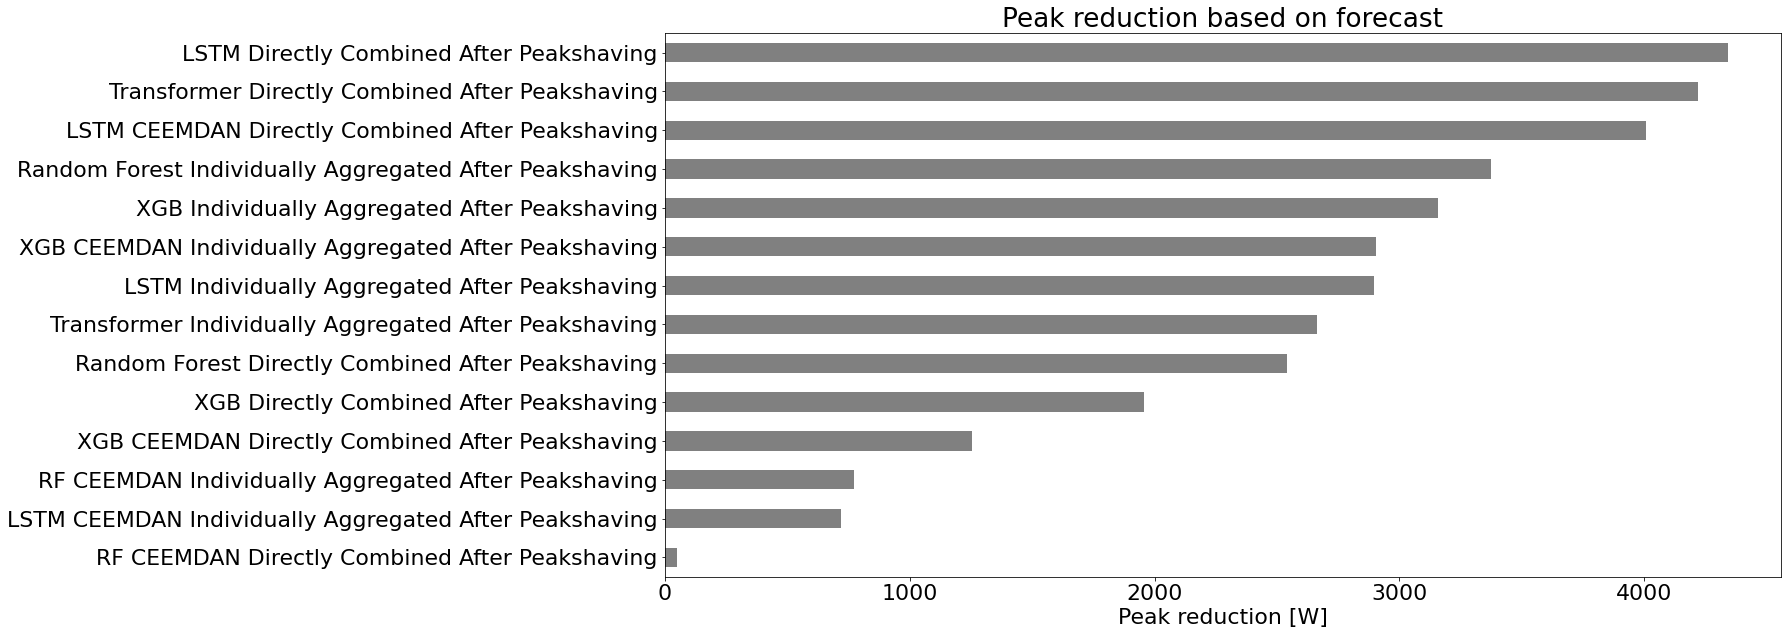

In [196]:
# Calculate Peak Reductions
peak_reductions = (after_peakshaving.max()["Real Load"]-after_peakshaving.max()).sort_values(ascending=True).iloc[1:]
peak_reductions.iloc[:-1].plot.barh(color="grey",figsize=(20,10),title="Peak reduction based on forecast",xlabel="Peak reduction [W]")



In [197]:
total_results_rank.loc["Peak Reductions [W]"] = peak_reductions
total_results.loc["Peak Reductions [W]"] = peak_reductions

total_results_rank

,Random Forest Individually Aggregated,Random Forest Directly Combined,RF CEEMDAN Individually Aggregated,RF CEEMDAN Directly Combined,XGB Individually Aggregated,XGB Directly Combined,XGB CEEMDAN Individually Aggregated,XGB CEEMDAN Directly Combined,LSTM Individually Aggregated,LSTM Directly Combined,LSTM CEEMDAN Individually Aggregated,LSTM CEEMDAN Directly Combined,Transformer Individually Aggregated,Transformer Directly Combined
MAPE,6.0,8.0,14.0,13.0,4.0,5.0,11.0,12.0,10.0,7.0,3.0,9.0,1.0,2.0
MAE,6.0,9.0,13.0,14.0,5.0,8.0,11.0,12.0,10.0,4.0,3.0,7.0,1.0,2.0
RMSE,5.0,10.0,13.0,14.0,7.0,9.0,11.0,12.0,8.0,4.0,3.0,6.0,1.0,2.0
R2,5.0,10.0,13.0,14.0,7.0,9.0,11.0,12.0,8.0,4.0,3.0,6.0,1.0,2.0
peak_rmse,6.0,9.0,12.0,14.0,7.0,8.0,11.0,13.0,10.0,5.0,3.0,4.0,2.0,1.0
peaktime_mae,2.0,4.0,5.0,11.0,8.0,12.0,13.0,6.0,14.0,3.0,7.0,10.0,1.0,9.0
peaktime_accuracy,8.0,4.0,2.0,11.0,13.0,10.0,6.0,2.0,14.0,6.0,9.0,12.0,1.0,5.0
RMSE_decile_0.5,6.0,9.0,12.0,14.0,7.0,10.0,11.0,13.0,8.0,4.0,3.0,5.0,1.0,2.0
RMSE_decile_0.3,4.0,9.0,11.0,14.0,7.0,10.0,12.0,13.0,6.0,2.0,8.0,5.0,3.0,1.0
RMSE_decile_0.2,4.0,8.0,11.0,14.0,5.0,9.0,12.0,13.0,6.0,1.0,10.0,7.0,3.0,2.0


In [198]:
for idx, row in total_results_rank.T.iterrows():
    total_results_rank.T.at[idx,"Peak Reductions [W]"] = peak_reductions[idx+" After Peakshaving"]
    total_results.T.at[idx,"Peak Reductions [W]"] = peak_reductions[idx+" After Peakshaving"]

    
total_results_rank
total_results

,Random Forest Individually Aggregated,Random Forest Directly Combined,RF CEEMDAN Individually Aggregated,RF CEEMDAN Directly Combined,XGB Individually Aggregated,XGB Directly Combined,XGB CEEMDAN Individually Aggregated,XGB CEEMDAN Directly Combined,LSTM Individually Aggregated,LSTM Directly Combined,LSTM CEEMDAN Individually Aggregated,LSTM CEEMDAN Directly Combined,Transformer Individually Aggregated,Transformer Directly Combined
MAPE,16.794425,17.238016,25.396165,22.941409,16.477318,16.579187,20.801822,21.311927,18.586965,17.031402,16.472842,17.660025,14.733808,15.596464
MAE,2377.941443,2466.568777,3274.447140,3277.455108,2375.881012,2432.933618,2913.927275,3056.005859,2508.320342,2360.203502,2314.982518,2426.390248,2128.143596,2198.400426
RMSE,3137.000265,3269.301888,4247.912603,4478.732110,3168.893192,3256.327808,3827.778104,4097.766837,3247.751677,3041.799347,3029.791322,3167.111943,2822.499817,2873.562057
R2,0.873561,0.862671,0.768153,0.742272,0.870977,0.863759,0.811746,0.784253,0.864476,0.881119,0.882056,0.871122,0.897643,0.893906
peak_rmse,3606.232313,3902.706452,4571.926044,4922.616678,3640.041331,3860.070439,4187.352241,4697.830750,4026.145823,3587.970172,3440.022251,3536.341830,3211.375192,3049.180158
peaktime_mae,4.360656,4.420765,4.560109,4.849727,4.655738,4.923497,4.991803,4.590164,6.081967,4.401639,4.653005,4.827869,3.830601,4.718579
peaktime_accuracy,14.207650,16.120219,16.666667,12.568306,11.475410,13.114754,15.027322,16.666667,10.382514,15.027322,13.661202,12.295082,17.759563,15.573770
RMSE_decile_0.5,3800.288872,3930.385426,4609.193121,5415.159693,3898.686247,3978.995715,4552.026892,4946.117123,3901.813753,3678.740431,3648.428381,3725.712672,3479.985023,3496.634850
RMSE_decile_0.3,3841.147935,3967.781035,4659.724714,5499.386658,3911.470040,4014.621236,4712.810965,4900.015777,3877.064094,3587.440019,3928.064371,3848.485746,3649.276546,3577.338793
RMSE_decile_0.2,3881.019066,4030.803114,4763.226940,5635.451204,3927.668665,4088.479265,4795.603692,4849.857952,3980.254752,3663.499506,4216.197870,4005.212423,3754.306260,3683.248247


## Cost optimization

<AxesSubplot: title={'center': 'Pearson correlation of metrics with achieved peak reduction'}, ylabel='Correlation'>

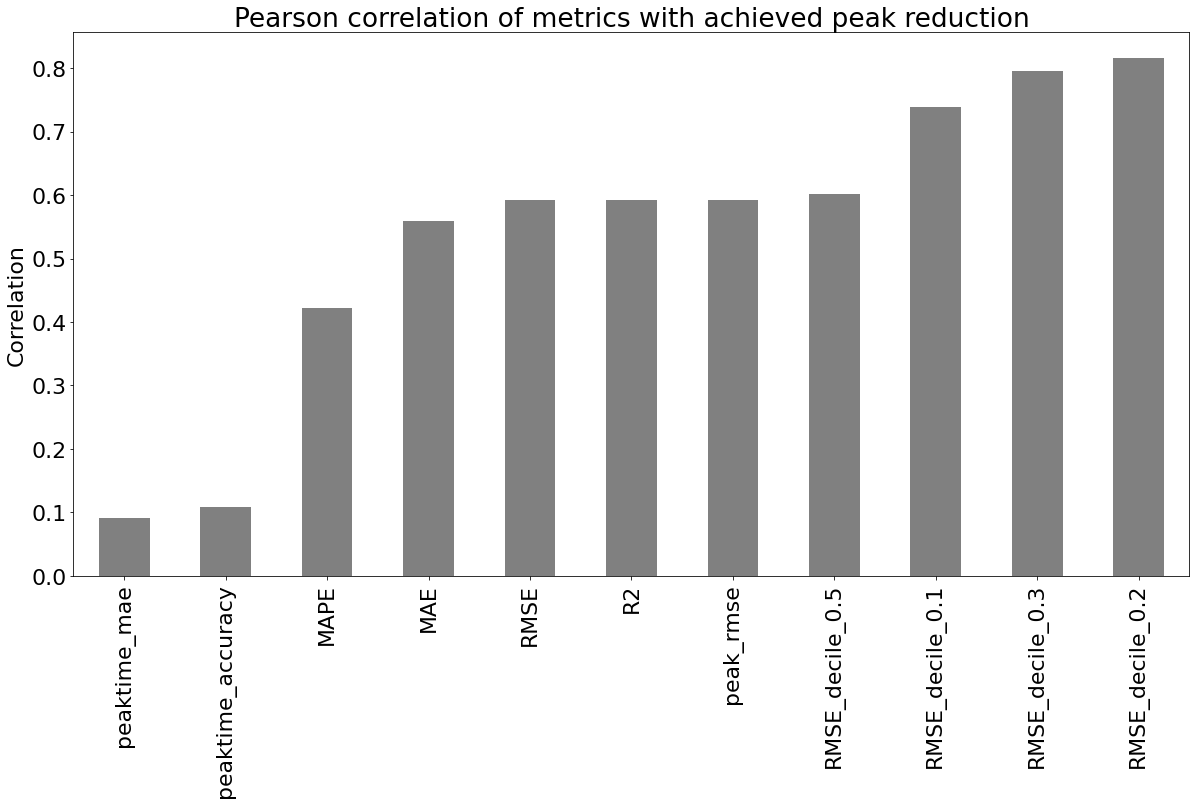

In [199]:
total_results_rank.T.corr().abs().sort_values(by="Peak Reductions [W]")["Peak Reductions [W]"].iloc[:-1].plot.bar(figsize=(20,10),color="grey",ylabel="Correlation",title="Pearson correlation of metrics with achieved peak reduction")


<AxesSubplot: title={'center': 'Pearson correlation of metrics with achieved peak reduction'}, ylabel='Correlation'>

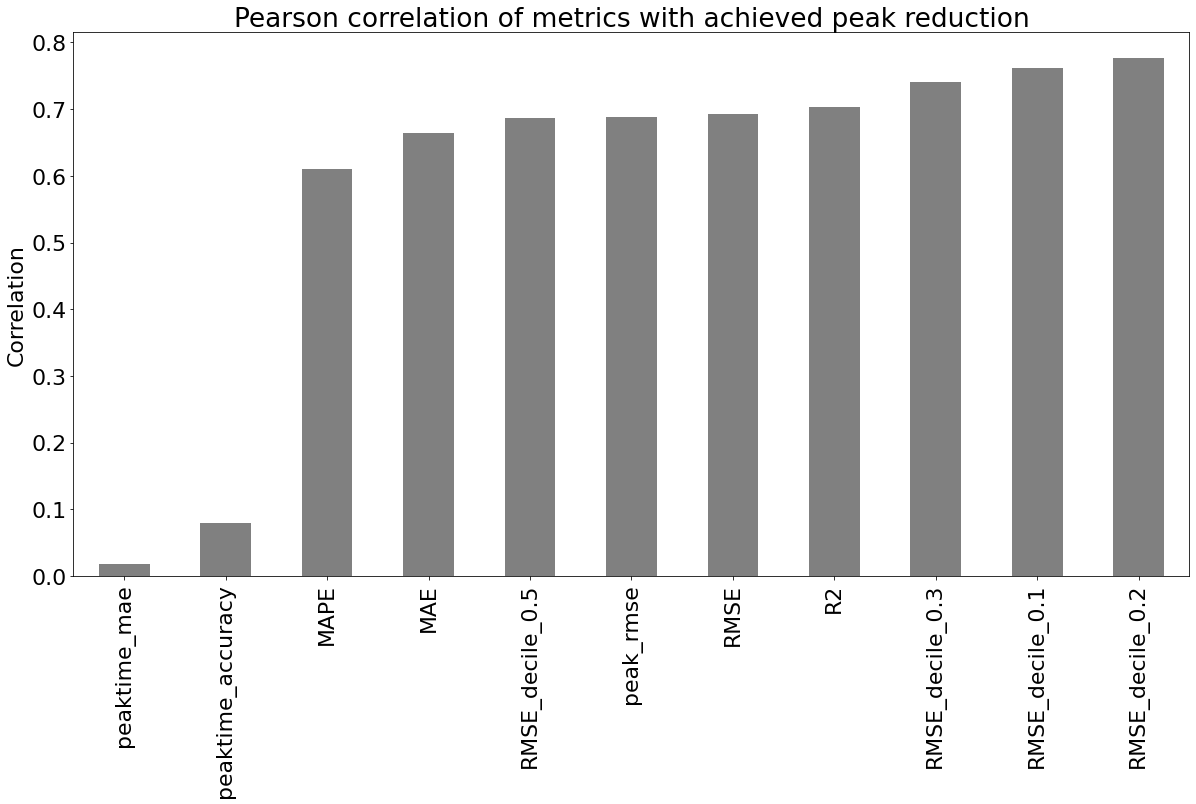

In [200]:
total_results.T.corr().abs().sort_values(by="Peak Reductions [W]")["Peak Reductions [W]"].iloc[:-1].plot.bar(figsize=(20,10),color="grey",ylabel="Correlation",title="Pearson correlation of metrics with achieved peak reduction")
